In [1]:
from common import plot_standings_v2, NWSL
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
week = 5
year = 2024

In [3]:
df = pd.read_csv("data/" + str(year) + "/1.csv", index_col=0)[["rank"]].rename(
    columns={"rank": "1"}
)
for i in range(2, week + 1):
    df_new = pd.read_csv("data/" + str(year) + "/" + str(i) + ".csv", index_col=0)[
        ["rank"]
    ].rename(columns={"rank": str(i)})
    df = df.join(df_new)
df

,1,2,3,4,5
team,,,,,
NC,1,3,3,2,4
CHI,2,1,2,4,3
KCC,3,2,1,1,1
BAY,4,7,10,6,8
RGN,5,5,11,12,13
ORL,6,9,8,5,5
LOU,7,10,9,9,6
NJNY,8,4,7,8,11
SD,9,13,6,7,10


In [4]:
# Create fake data for the standings table
df_table = pd.read_csv("data/" + str(year) + "/" + str(week) +".csv", index_col=0)
df_table

,rank,PTS,MP,W,L,D,GF,GA,GD
team,,,,,,,,,
KCC,1,13,5,4,0,1,17,10,7
WAS,2,12,5,4,1,0,9,4,5
CHI,3,10,5,3,1,1,7,4,3
NC,4,9,5,3,2,0,10,5,5
ORL,5,9,5,2,0,3,6,4,2
LOU,6,7,5,1,0,4,9,5,4
LA,7,7,5,2,2,1,6,7,-1
BAY,8,6,5,2,3,0,9,12,-3
POR,9,4,5,1,3,1,10,11,-1


In [28]:
from common import Fonts, Images, Colors, add_twitter_handle
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d


def interpolate_base(cubic_p):
    x1 = 0
    y1 = 0
    x2 = 1
    y2 = 1
    steps = np.linspace(0, cubic_p, 10)
    x = list(map(lambda i: x1 + i, steps)) + list(map(lambda i: x2 - i, steps[::-1]))
    y = [y1] * len(steps) + [y2] * len(steps)
    f = interp1d(x, y, kind="quadratic")
    xs = np.linspace(x1, x2, num=40)
    ys = f(xs)

    return (xs, ys)


def interpolate(x1, y1, x2, y2):
    (xs, ys) = interpolate_base(0.15)
    for i in range(0, len(xs)):
        xs[i] = x1 + xs[i] * (x2 - x1)
        ys[i] = y1 + ys[i] * (y2 - y1)

    return (xs, ys)


def plot_standings_v2(
    df_original,
    df_table_original,
    folder,
    names,
    colors,
    text_colors,
    title,
    label_overlap=0.06,
    label_width=0.37,
    twitter_x=0.88,
    plot_ratio=0.8,
    title_x=0.5,
):
    font_size = 30

    # Make deep copy to avoid changing the input
    df = df_original.copy()
    df_table = df_table_original.copy()

    # Get the week number
    week = int(df.columns[-1])

    # Sort so top teams have lines drawn on top
    df = df.sort_values(by=[str(week)], ascending=False)

    # Set up the plot and axes
    plt.clf()
    fig = plt.figure(
        dpi=100,
        figsize=(week + 15 + len(df_table_original.columns) * 0.2, 15.5),
        facecolor=Colors.WHITE,
    )
    ax0 = fig.add_axes([0, 0, plot_ratio, 0.85])
    ax1 = fig.add_axes(
        [plot_ratio - label_overlap, 0, 1 - (plot_ratio - label_overlap), 0.85]
    )
    axs = [ax0, ax1]

    for ax in axs:
        ax.set_facecolor(Colors.WHITE)

    # Plot scatterplot
    ax = axs[0]

    # Background lines for each team's progress
    for team in df.index:
        x = list(map(lambda j: int(j) - 1, list(df.columns)))
        y = df.loc[team].to_numpy()

        # Interpolate data to get smooth lines
        x2, y2 = [], []
        for xi, yi in zip(x, y):
            if len(x2) == 0:
                x2.append(xi)
                y2.append(yi)
            else:
                xs, ys = interpolate(x2[-1], y2[-1], xi, yi)
                x2.extend(xs)
                y2.extend(ys)
        ax.plot(x2, y2, linewidth=5, color=colors[team], solid_capstyle="round")

    # Circles for each week
    for team in df.index:
        ax.scatter(df.columns, df.loc[team], s=1600, color=colors[team], zorder=10)

    # General
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)

    # y-axis
    ax.set_yticks([])
    ax.set_ylim([14.5, 0.5])
    ax.yaxis.grid(False)

    # x-axis
    ax.set_xticks(range(0, week))
    ax.set_xlim([-0.3, week - 0.75])
    ax.xaxis.grid(True, color=Colors.LIGHT_GRAY)
    ax.tick_params(
        axis="x", which="major", labelsize=font_size, color=Colors.GRAY, bottom=False
    )
    ax.set_xlabel(
        "Week", fontproperties=Fonts.BARLOW, size=32, color=Colors.BLACK, ha="center"
    )
    ax.xaxis.set_label_coords(0.5, -0.05)

    # Table plot
    ax = axs[1]

    for team in df.index:
        # Background behind team
        ax.plot(
            [0, label_width],
            [df.at[team, str(week)], df.at[team, str(week)]],
            linewidth=41,
            color=colors[team],
            solid_capstyle="round",
            clip_on=False,
        )
        # Team label
        ax.text(
            label_width / 2,
            df.at[team, str(week)],
            names[team],
            color=text_colors[team],
            fontsize=font_size,
            fontproperties=Fonts.BARLOW,
            va="center",
            ha="center",
        )

        # Team stats
        for i, col in enumerate(df_table.columns):
            ax.text(
                label_width + 0.11 + i * 0.12,
                df.at[team, str(week)],
                df_table.at[team, col],
                color=Colors.BLACK,
                fontsize=font_size,
                fontproperties=Fonts.BARLOW,
                va="center",
                ha="center",
            )

    # Stat headers
    ax.text(
        0,
        0,
        "Team",
        color=Colors.BLACK,
        fontsize=font_size,
        fontproperties=Fonts.BARLOW_BOLD,
        va="center",
        ha="left",
    )
    for i, col in enumerate(df_table.columns):
        ax.text(
            label_width + 0.11 + i * 0.12,
            0,
            col,
            color=Colors.BLACK,
            fontsize=font_size,
            fontproperties=Fonts.BARLOW_BOLD,
            va="center",
            ha="center",
        )

    # Set axes to match line chart
    ax.set_ylim([14.5, 0.5])
    ax.set_xlim([0, 0.9])
    ax.axis("off")

    # Title
    plt.suptitle(
        title,
        fontproperties=Fonts.BARLOW_BOLD,
        size=48,
        color=Colors.BLACK,
        y=0.98,
        x=title_x,
    )

    # Twitter logo and username
    add_twitter_handle(fig, x=twitter_x, y=-0.065, fs=24, w=0.03)

    # Save image
    fig.tight_layout()
    plt.savefig(
        folder + "/week" + str(week) + ".png", bbox_inches="tight", pad_inches=0.5
    )

<ipython-input-28-28534b10b67c>:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


<Figure size 432x288 with 0 Axes>

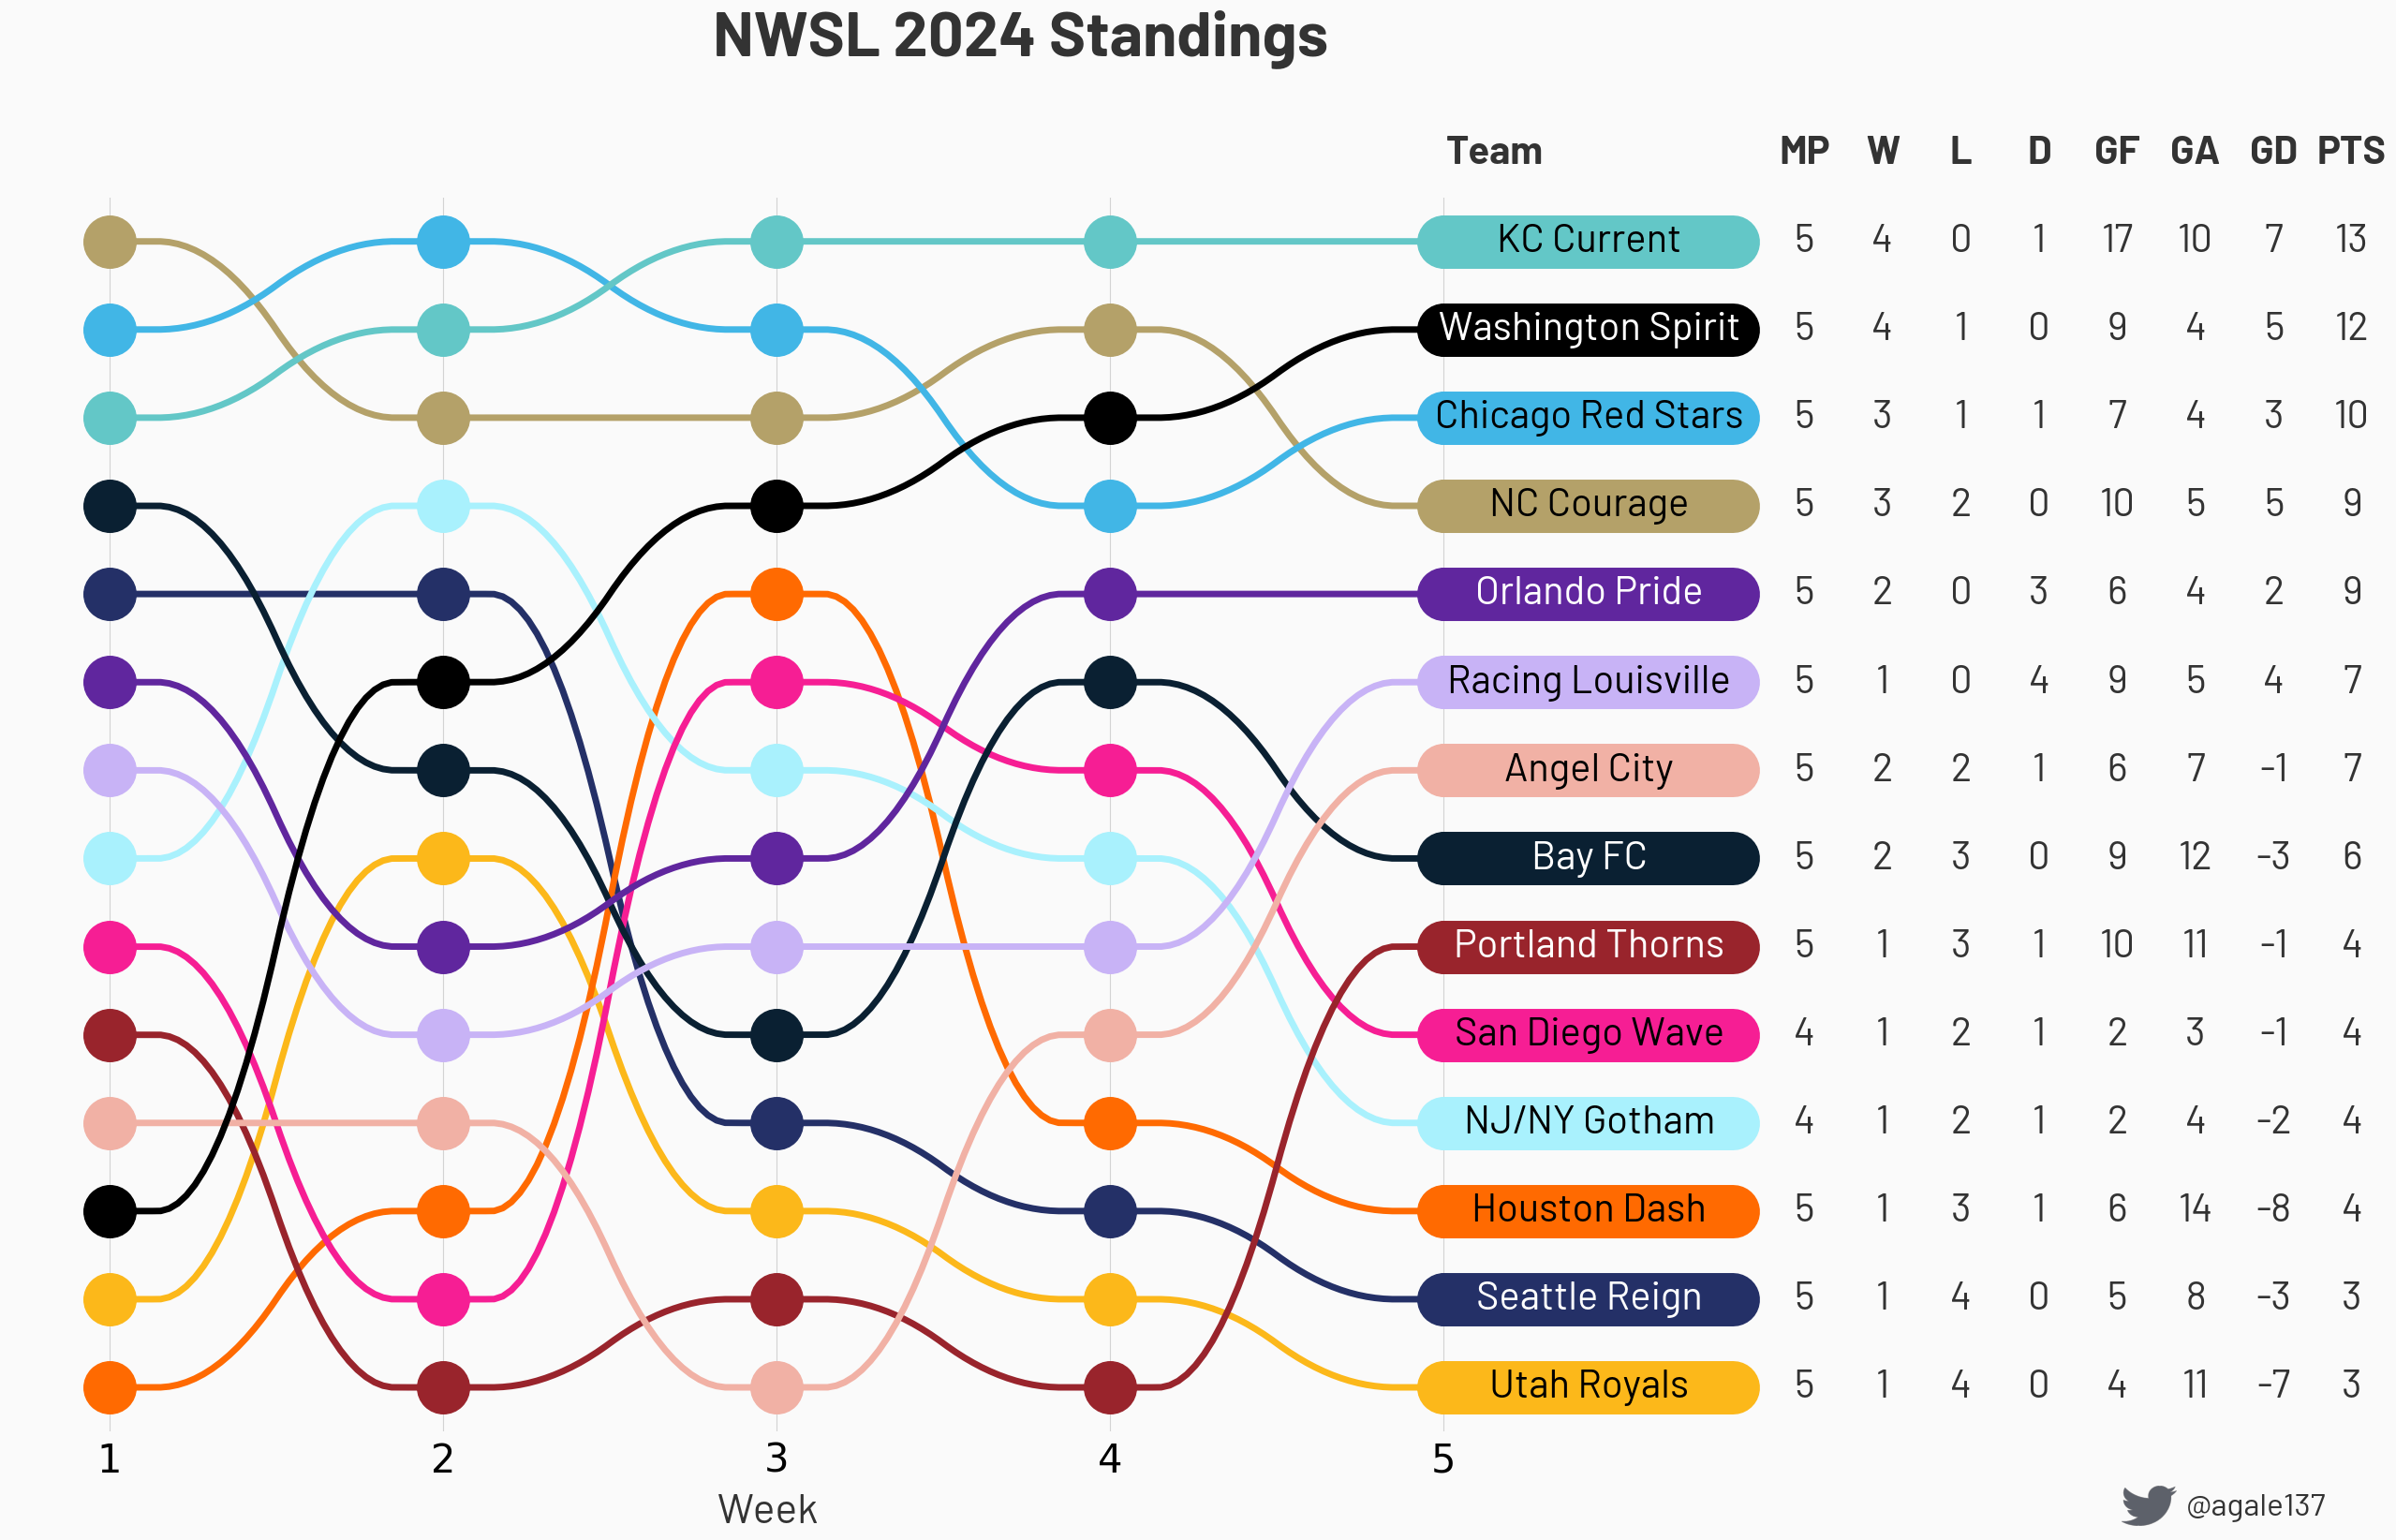

In [45]:
plot_standings_v2(
    df,
    df_table[["MP", "W", "L", "D", "GF", "GA", "GD", "PTS"]],
    folder="images/" + str(year),
    names=NWSL.NAMES,
    colors=NWSL.COLORS,
    text_colors=NWSL.TEXT_COLORS,
    title="NWSL " + str(year) + " Standings",
    label_width=0.44,
    label_overlap=0.04,
    twitter_x=1.04,
    plot_ratio=0.75,
    title_x=0.5,
)